# Big Data Analytics Project 

In [2]:
import pandas as pd

# Load the JSON file into a Pandas DataFrame
salesdf = pd.read_json('sales.json', lines=True)


# Intro: Install necessary libaries

In [3]:
!pip install pandas

In [4]:
num_rows, num_columns = salesdf.shape

print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}")

Number of Rows: 5000
Number of Columns: 7


# 1. Show top 10 products (name) sales (quantity x price)

In [5]:
from IPython.display import display, HTML

# Assuming 'salesdf' is your DataFrame
html_table = salesdf.head(3).to_html(classes='customtable', index=False)

# Define custom CSS styles to color the header
styles = """
    <style>
        .customtable {
            border-collapse: collapse;
            width: 100%;
        }
        .customtable th {
            background-color: #4e20ce; /* background color for header */
            color: white; /* White text color for header */
            border: 1px solid black;
            padding: 8px;
            text-align: left;
        }
        .customtable td {
            border: 1px solid black;
            padding: 8px;
            text-align: left;
        }
    </style>
"""

# Display the HTML with custom styles
display(HTML(styles + html_table))


_id,saleDate,items,storeLocation,customer,couponUsed,purchaseMethod
{'$oid': '5bd761dcae323e45a93ccfe8'},{'$date': '2015-03-23T21:06:49.506Z'},"[{'name': 'printer paper', 'tags': ['office', 'stationary'], 'price': {'$numberDecimal': '40.01'}, 'quantity': 2}, {'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '35.29'}, 'quantity': 2}, {'name': 'pens', 'tags': ['writing', 'office', 'school', 'stationary'], 'price': {'$numberDecimal': '56.12'}, 'quantity': 5}, {'name': 'backpack', 'tags': ['school', 'travel', 'kids'], 'price': {'$numberDecimal': '77.71'}, 'quantity': 2}, {'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '18.47'}, 'quantity': 2}, {'name': 'envelopes', 'tags': ['stationary', 'office', 'general'], 'price': {'$numberDecimal': '19.95'}, 'quantity': 8}, {'name': 'envelopes', 'tags': ['stationary', 'office', 'general'], 'price': {'$numberDecimal': '8.08'}, 'quantity': 3}, {'name': 'binder', 'tags': ['school', 'general', 'organization'], 'price': {'$numberDecimal': '14.16'}, 'quantity': 3}]",Denver,"{'gender': 'M', 'age': 42, 'email': 'cauho@witwuta.sv', 'satisfaction': 4}",True,Online
{'$oid': '5bd761dcae323e45a93ccfe9'},{'$date': '2015-08-25T10:01:02.918Z'},"[{'name': 'envelopes', 'tags': ['stationary', 'office', 'general'], 'price': {'$numberDecimal': '8.05'}, 'quantity': 10}, {'name': 'binder', 'tags': ['school', 'general', 'organization'], 'price': {'$numberDecimal': '28.31'}, 'quantity': 9}, {'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '20.95'}, 'quantity': 3}, {'name': 'laptop', 'tags': ['electronics', 'school', 'office'], 'price': {'$numberDecimal': '866.5'}, 'quantity': 4}, {'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '33.09'}, 'quantity': 4}, {'name': 'printer paper', 'tags': ['office', 'stationary'], 'price': {'$numberDecimal': '37.55'}, 'quantity': 1}, {'name': 'backpack', 'tags': ['school', 'travel', 'kids'], 'price': {'$numberDecimal': '83.28'}, 'quantity': 2}, {'name': 'pens', 'tags': ['writing', 'office', 'school', 'stationary'], 'price': {'$numberDecimal': '42.9'}, 'quantity': 4}, {'name': 'envelopes', 'tags': ['stationary', 'office', 'general'], 'price': {'$numberDecimal': '16.68'}, 'quantity': 2}]",Seattle,"{'gender': 'M', 'age': 50, 'email': 'keecade@hem.uy', 'satisfaction': 5}",False,Phone
{'$oid': '5bd761dcae323e45a93ccfea'},{'$date': '2017-06-22T09:54:14.185Z'},"[{'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '30.08'}, 'quantity': 1}, {'name': 'binder', 'tags': ['school', 'general', 'organization'], 'price': {'$numberDecimal': '24.68'}, 'quantity': 7}, {'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '32.1'}, 'quantity': 4}, {'name': 'pens', 'tags': ['writing', 'office', 'school', 'stationary'], 'price': {'$numberDecimal': '31.41'}, 'quantity': 3}, {'name': 'printer paper', 'tags': ['office', 'stationary'], 'price': {'$numberDecimal': '43.56'}, 'quantity': 3}, {'name': 'pens', 'tags': ['writing', 'office', 'school', 'stationary'], 'price': {'$numberDecimal': '68.95'}, 'quantity': 4}, {'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '8.57'}, 'quantity': 4}, {'name': 'backpack', 'tags': ['school', 'travel', 'kids'], 'price': {'$numberDecimal': '106.6'}, 'quantity': 2}, {'name': 'laptop', 'tags': ['electronics', 'school', 'office'], 'price': {'$numberDecimal': '596.33'}, 'quantity': 4}]",Denver,"{'gender': 'M', 'age': 51, 'email': 'worbiduh@vowbu.cg', 'satisfaction': 5}",False,In store


In [6]:

# Extract relevant information from the 'items' column
items_df = pd.json_normalize(salesdf['items'].explode()).reset_index()

In [7]:

# Assuming 'items_df' is another DataFrame
head_rows = items_df.head(3)
tail_rows = items_df.tail(3)

# Add a row with "..." to indicate skipped rows
ellipsis_row = pd.DataFrame(["..."] * len(head_rows.columns)).T
ellipsis_row.columns = head_rows.columns
table_with_ellipsis = pd.concat([head_rows, ellipsis_row, tail_rows])

# Convert to HTML
html_table = table_with_ellipsis.head(5).to_html(classes='customtable', index=False)

# Display the HTML with custom styles for items_df
display(HTML(styles + html_table))

index,name,tags,quantity,price.$numberDecimal
0,printer paper,"[office, stationary]",2,40.01
1,notepad,"[office, writing, school]",2,35.29
2,pens,"[writing, office, school, stationary]",5,56.12
...,...,...,...,...
27435,binder,"[school, general, organization]",3,29.09


In [8]:
# Assuming 'items_df' is your DataFrame
items_df['sales'] = items_df['quantity'] * items_df['price.$numberDecimal'].astype(float)

# Group by product name and calculate total sales
product_sales = items_df.groupby('name')['sales'].sum().reset_index()

# Select the top 10 products based on total sales
Top_10_Product_Sales = product_sales.sort_values(by='sales', ascending=False).head(10)

# Add a new column 'rank' with numbers (1, 2, 3, ...)
Top_10_Product_Sales.insert(0, 'Top10', range(1, len(Top_10_Product_Sales) + 1))

# Convert to HTML
html_table = Top_10_Product_Sales.to_html(classes='customtable', index=False)

# Add a title to the table
table_title = '<h2>Top 10 Product Sales (Quantity x Price)    <--------</h2>'

# Display the HTML with custom styles for Top_10_Product_Sales
display(HTML(styles + table_title + html_table))


Top10,name,sales
1,laptop,6775977.07
2,backpack,817374.10
3,pens,581843.27
4,binder,511644.57
5,notepad,463615.48
6,envelopes,376658.49
7,printer paper,367459.29


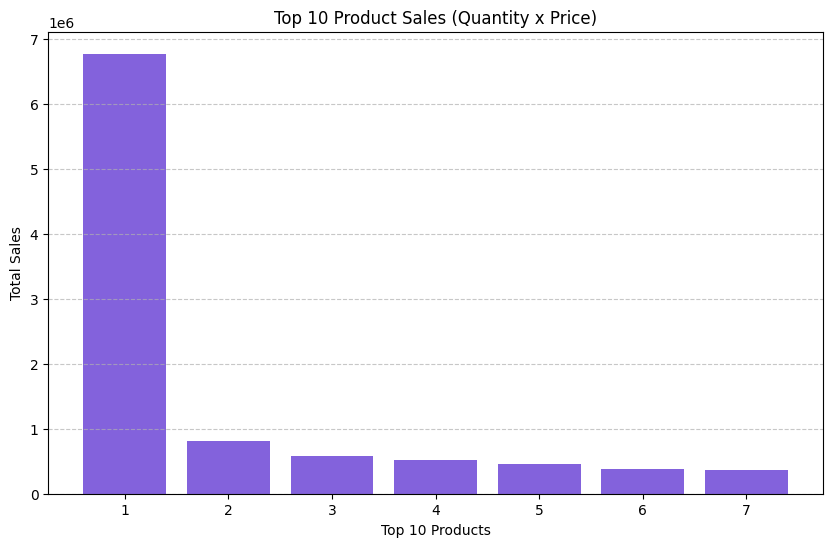

In [9]:
import matplotlib.pyplot as plt

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(Top_10_Product_Sales['Top10'], Top_10_Product_Sales['sales'], color='#4e20ce', alpha=0.7)
plt.xlabel('Top 10 Products')
plt.ylabel('Total Sales')
plt.title('Top 10 Product Sales (Quantity x Price)')
plt.xticks(Top_10_Product_Sales['Top10'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


# 2.Show Top 3 Products (name) Sales by  Store(location)

In [10]:
salesbystore = salesdf[['storeLocation','purchaseMethod','saleDate']].reset_index()

In [11]:
merged_df = pd.merge(items_df,salesbystore, left_on='index', right_on='index')
html_table = merged_df.head().to_html(classes='customtable', index=False)
display(HTML(styles + html_table))


index,name,tags,quantity,price.$numberDecimal,sales,storeLocation,purchaseMethod,saleDate
0,printer paper,"[office, stationary]",2,40.01,80.02,Denver,Online,{'$date': '2015-03-23T21:06:49.506Z'}
1,notepad,"[office, writing, school]",2,35.29,70.58,Seattle,Phone,{'$date': '2015-08-25T10:01:02.918Z'}
2,pens,"[writing, office, school, stationary]",5,56.12,280.60,Denver,In store,{'$date': '2017-06-22T09:54:14.185Z'}
3,backpack,"[school, travel, kids]",2,77.71,155.42,Seattle,In store,{'$date': '2015-02-23T09:53:59.343Z'}
4,notepad,"[office, writing, school]",2,18.47,36.94,London,In store,{'$date': '2017-12-03T18:39:48.253Z'}


In [12]:
# Assuming 'merged_df' is your DataFrame
top_3_productsales_by_store = (
    merged_df.groupby(['storeLocation', 'name'])['sales']
    .sum()
    .reset_index()
    .sort_values(by=['storeLocation', 'sales'], ascending=[True, False])
    .groupby('storeLocation')
    .head(3)
)

# Add a new column 'rank' with numbers (1, 2, 3, ...)
top_3_productsales_by_store.insert(0, 'Top3', range(1, len(top_3_productsales_by_store) + 1))

# Convert to HTML
html_table = top_3_productsales_by_store.to_html(classes='customtable', index=False)

# Add a title to the table
table_title = '<h2>Top 3 Product Sales by Store   <--------</h2>'

# Display the HTML with custom styles for top_3_productsales_by_store
display(HTML(styles + table_title + html_table))


Top3,storeLocation,name,sales
1,Austin,laptop,158970.49
2,Austin,backpack,23265.19
3,Austin,binder,13618.05
4,Denver,laptop,409752.19
5,Denver,backpack,44224.19
6,Denver,pens,32667.76
7,London,laptop,201480.89
8,London,backpack,22946.59
9,London,pens,17510.10
10,New York,laptop,177308.46


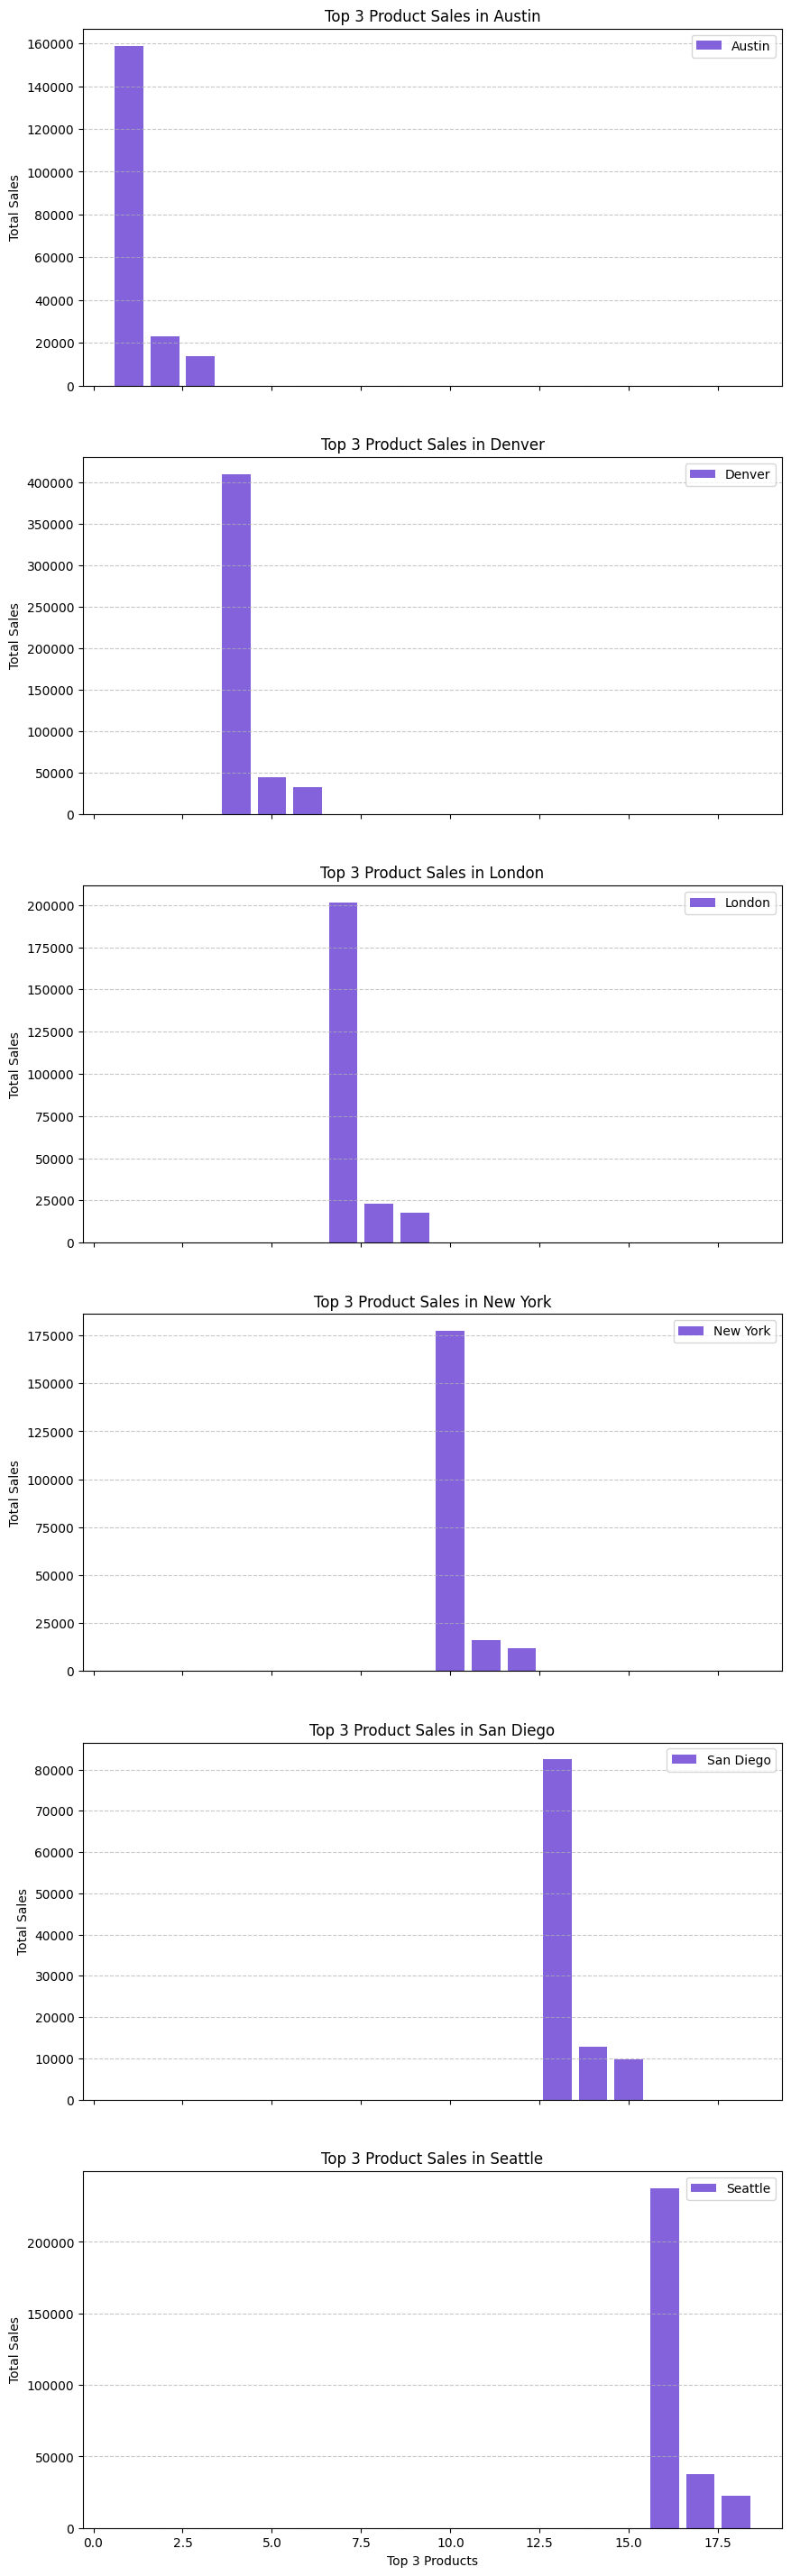

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Separate data for each store
stores = top_3_productsales_by_store['storeLocation'].unique()

# Set up subplots
fig, axes = plt.subplots(len(stores), 1, figsize=(10, 6 * len(stores)), sharex=True)

for i, store in enumerate(stores):
    # Filter data for the current store
    store_data = top_3_productsales_by_store[top_3_productsales_by_store['storeLocation'] == store]
    
    # Plotting the bar chart for the current store
    axes[i].bar(store_data['Top3'], store_data['sales'], color='#4e20ce', alpha=0.7, label=store)
    axes[i].set_ylabel('Total Sales')
    axes[i].set_title(f'Top 3 Product Sales in {store}')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i].legend()

# Set common x-axis label
plt.xlabel('Top 3 Products')

# Display the plot
plt.show()


# 3.Show rankings of each store (location)

In [16]:
# Group by store location and calculate total sales
store_rankings = merged_df.groupby('storeLocation')['sales'].sum().reset_index()
# Convert to HTML
html_table = store_rankings.head(3).to_html(classes='customtable', index=False)

# Display the HTML with custom styles for top_3_productsales_by_store
display(HTML(styles + html_table))

storeLocation,sales
Austin,237868.30
Denver,583256.15
London,291162.89


In [17]:
# Sort the values by total sales in descending order
store_rankings = store_rankings.sort_values(by='sales', ascending=False)

# Add a rank column based on total sales
store_rankings['rank'] = range(1, len(store_rankings) + 1)

# Convert to HTML
html_table = store_rankings.head().to_html(classes='customtable', index=False)

# Add a title to the table
table_title = '<h2>Ranking of Each Store   <--------</h2>'

# Display the HTML with custom styles for top_3_productsales_by_store
display(HTML(styles +table_title+ html_table))

storeLocation,sales,rank
Denver,583256.15,1
Seattle,370600.53,2
London,291162.89,3
Austin,237868.30,4
New York,233406.01,5


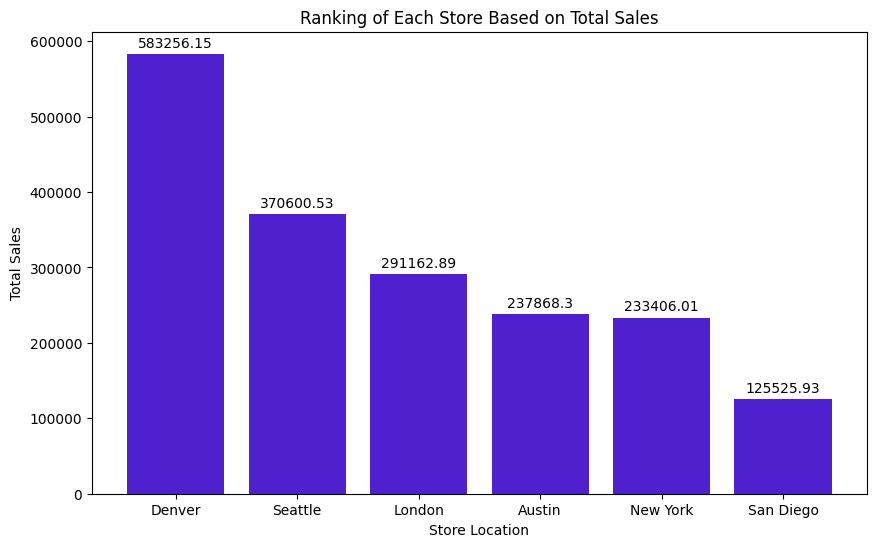

In [20]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the color for the bars to #4e20ce
bar_color = '#4e20ce'

# Plot the bar chart
ax.bar(store_rankings['storeLocation'], store_rankings['sales'], color=bar_color)

# Add labels and title
ax.set_xlabel('Store Location')
ax.set_ylabel('Total Sales')
ax.set_title('Ranking of Each Store Based on Total Sales')

# Add values on top of the bars
for i, v in enumerate(store_rankings['sales']):
    ax.text(i, v + 5000, str(v), ha='center', va='bottom')

# Show the plot
plt.show()



# 4.Show purchased method by gender table 

In [21]:
print(merged_df['purchaseMethod'].unique())

['Online' 'Phone' 'In store']


In [22]:

# Assuming customer information is in a column named 'customer'
customer_df = salesdf['customer'].apply(pd.Series)
# Merge the customer information with the items information
merged_customer_df = pd.merge(merged_df, customer_df, left_on='index', right_index=True)
# Convert to HTML
html_table = merged_customer_df.head().to_html(classes='customtable', index=False)

# Display the HTML with custom styles for top_3_productsales_by_store
display(HTML(styles + html_table))

index,name,tags,quantity,price.$numberDecimal,sales,storeLocation,purchaseMethod,saleDate,gender,age,email,satisfaction
0,printer paper,"[office, stationary]",2,40.01,80.02,Denver,Online,{'$date': '2015-03-23T21:06:49.506Z'},M,42,cauho@witwuta.sv,4
1,notepad,"[office, writing, school]",2,35.29,70.58,Seattle,Phone,{'$date': '2015-08-25T10:01:02.918Z'},M,50,keecade@hem.uy,5
2,pens,"[writing, office, school, stationary]",5,56.12,280.60,Denver,In store,{'$date': '2017-06-22T09:54:14.185Z'},M,51,worbiduh@vowbu.cg,5
3,backpack,"[school, travel, kids]",2,77.71,155.42,Seattle,In store,{'$date': '2015-02-23T09:53:59.343Z'},F,45,vatires@ta.pe,3
4,notepad,"[office, writing, school]",2,18.47,36.94,London,In store,{'$date': '2017-12-03T18:39:48.253Z'},M,40,dotzu@ib.sh,4


In [23]:
# Assuming 'purchaseMethod' is a column in your dataframe
purchase_by_gender = pd.crosstab(merged_customer_df['gender'], merged_customer_df['purchaseMethod'])

table_title = 'Purchase by Gender <-------'
print(table_title)
print()

# Display the table
print(purchase_by_gender)


Purchase by Gender <-------

purchaseMethod  In store  Online  Phone
gender                                 
F                   1430     813    284
M                   1389     772    312


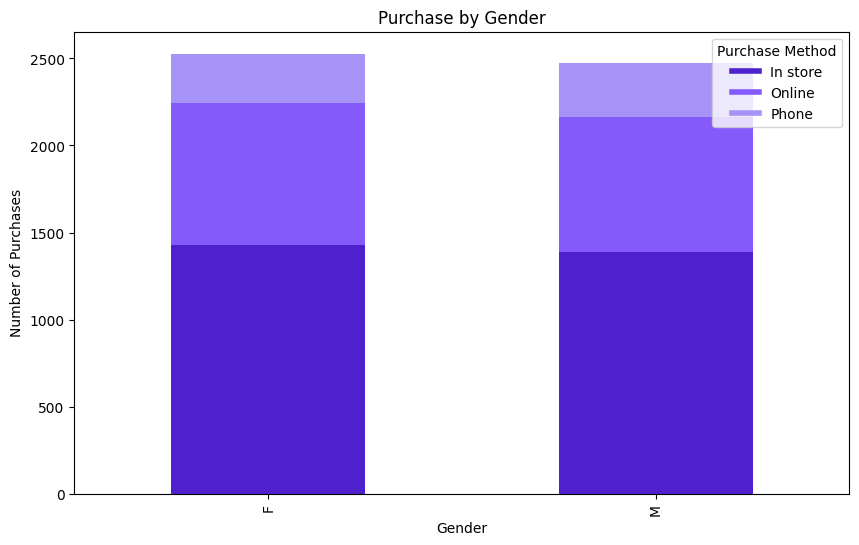

In [33]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each purchase method
colors = {'In store': '#4e20ce', 'Online': '#845afa', 'Phone': '#a793f7'}

# Plot the bar chart with custom colors
purchase_by_gender.plot(kind='bar', stacked=True, ax=ax, color=[colors[method] for method in purchase_by_gender.columns])

# Add labels and title
ax.set_xlabel('Gender')
ax.set_ylabel('Number of Purchases')
ax.set_title('Purchase by Gender')

# Add legend with custom colors
legend_labels = [plt.Line2D([0], [0], color=colors[method], lw=4, label=method) for method in purchase_by_gender.columns]
ax.legend(handles=legend_labels, title='Purchase Method', loc='upper right')

# Show the plot
plt.show()


# 5.Show monthly total sales 

In [34]:
# Assuming 'saleDate' is the column containing date information
merged_customer_df['saleDate'] = merged_customer_df['saleDate'].apply(
    lambda x: x['$date'] if isinstance(x, dict) else x
)

# Convert 'saleDate' to datetime format
merged_customer_df['saleDate'] = pd.to_datetime(
    merged_customer_df['saleDate'], format="%Y-%m-%dT%H:%M:%S.%fZ", errors='coerce'
)

# Drop rows with non-finite (NA or inf) values in 'saleDate'
merged_customer_df = merged_customer_df.dropna(subset=['saleDate'])

# Extracting year and month from 'saleDate'
merged_customer_df['year'] = merged_customer_df['saleDate'].dt.year
merged_customer_df['month'] = merged_customer_df['saleDate'].dt.month

# Convert 'month' and 'year' to integer type
merged_customer_df['month'] = merged_customer_df['month'].astype(int)
merged_customer_df['year'] = merged_customer_df['year'].astype(int)

# Assuming 'sales' is the column representing sales amount
# If it's not present, you may need to check how the sales data is stored in your DataFrame
monthly_total_sales = merged_customer_df.groupby(['year', 'month']).agg({'sales': 'sum'}).reset_index()

# Convert to HTML
html_table = monthly_total_sales.to_html(classes='customtable', index=False)

# Add a title to the table
table_title = '<h2>Monthly Total Sales   <--------</h2>'

# Display the HTML with custom styles for top_3_productsales_by_store
display(HTML(styles + table_title + html_table))



year,month,sales
2013,1,22516.78
2013,2,29306.27
2013,3,19943.84
2013,4,38496.15
2013,5,27018.06
2013,6,33785.74
2013,7,25126.67
2013,8,20167.53
2013,9,27709.83
2013,10,29965.56


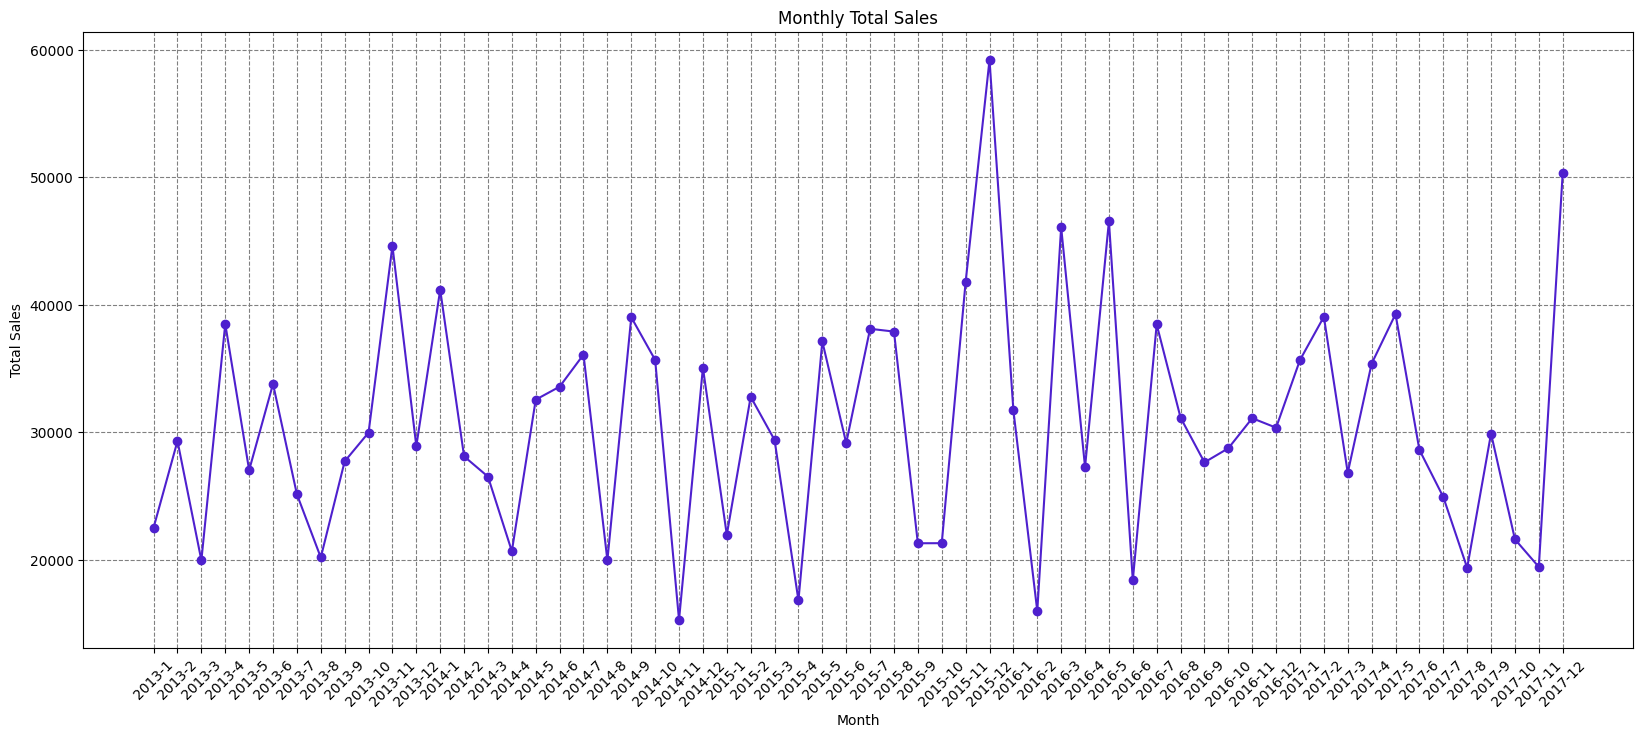

In [43]:
import matplotlib.pyplot as plt

# Set up the figure and axes with a larger figsize
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the line chart with the trendline color set to #4e20ce
ax.plot(monthly_total_sales['year'].astype(str) + '-' + monthly_total_sales['month'].astype(str), 
        monthly_total_sales['sales'], marker='o', color='#4e20ce')

# Add labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Total Sales')
ax.set_title('Monthly Total Sales')

# Change the color of the gridlines to #4e20ce
ax.grid(True, linestyle='--', color='grey')

# Show the plot
plt.xticks(rotation=45)
plt.show()



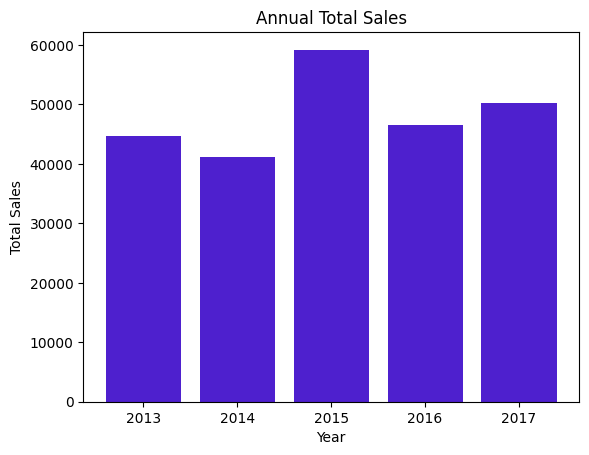

In [44]:
import matplotlib.pyplot as plt

# Assuming 'year' is the column representing the years
# 'total_sales' is the column representing total sales for each year
plt.bar(monthly_total_sales['year'], monthly_total_sales['sales'], color='#4e20ce')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Annual Total Sales')
plt.show()
